In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from itertools import product

In [3]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")
y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

y_val = external_validation_cohort['Outcome_Occlusion_MI']
X_val = external_validation_cohort.drop('Outcome_Occlusion_MI', axis=1)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_test = scaler.transform(X_test, copy=True) # Standardize X_test using training mean and std
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_104744\2918519399.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_104744\2918519399.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [4]:
# 1. Train the best model on the entire training set
best_xgb = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0,
        tree_method="hist",
        n_jobs=-1,
        random_state=42)

# Fit the model on the entire training set
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'XGB (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

External Validation (Test)


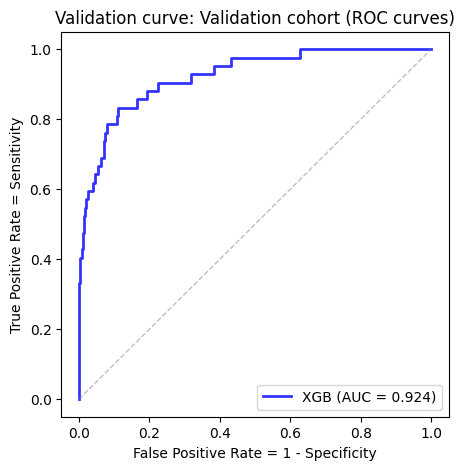

Val AUROC: 0.924 (95% CI: 0.880, 0.961)


In [18]:
print("External Validation (Test)")
pred_probas_test = best_xgb.predict_proba(X_test)
risk_groups_test = results(pred_probas_test)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probas_test[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Validation curve: Validation cohort (ROC curves)')
#plot_Shapley(clf, X_test, columns, 'Derivation cohort', 25)
# Compute AUROC CI
auroc_ci_lower_test, auroc_ci_upper_test = bootstrap_metric_ci(y_test, pred_probas_test[:,1], "auroc")

print(f"Val AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_test:.3f}, {auroc_ci_upper_test:.3f})")

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

def determine_optimal_thresholds(y_test, pred_probas_test, figsize=(12, 5), n_bins=50):
    """
    Create probability density plot for OMI(+) and OMI(-) classes and determine
    optimal thresholds for risk stratification.
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    figsize : tuple
        Figure size
    n_bins : int
        Number of bins for the histogram
    
    Returns:
    --------
    tuple
        (low_threshold, high_threshold)
    """
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot density distributions
    sns.kdeplot(neg_probs, ax=ax, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Determine the thresholds visually (helper guidelines)
    for percentile in range(5, 100, 5):
        # Vertical line at each 5th percentile of the negative distribution
        threshold = np.percentile(neg_probs, percentile)
        if threshold <= 50:  # Only show for the first half of the distribution
            ax.axvline(x=threshold, color='gray', linestyle=':', alpha=0.3)
            ax.text(threshold, -0.01, f"{percentile}%", ha='center', fontsize=8, rotation=90)
    
    # Determine initial guess for thresholds
    low_guess = np.percentile(neg_probs, 90)  # 90th percentile of negatives for sensitivity
    high_guess = np.percentile(pos_probs, 40)  # 40th percentile of positives for specificity
    
    # Mark initial guesses
    ax.axvline(x=low_guess, color='black', linestyle='--', alpha=0.7, label=f'Low Threshold ({low_guess:.1f})')
    ax.axvline(x=high_guess, color='black', linestyle='--', alpha=0.7, label=f'High Threshold ({high_guess:.1f})')
    
    # Set axis labels and title
    ax.set_xlabel("Probability Score (0-100)")
    ax.set_ylabel("Density")
    ax.set_title("OMI(+) and OMI(-) Probability Distributions")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Let's evaluate different threshold combinations
    print("Evaluating multiple threshold combinations...")
    
    # We'll search through reasonable ranges
    # Use a broader range of thresholds to explore
    low_thresholds = np.linspace(3, 5, 10)   # Try even lower thresholds
    high_thresholds = np.linspace(15, 25, 10)  # Try lower high thresholds
    
    results = []
    
    for low_t in low_thresholds:
        for high_t in high_thresholds:
            # Create risk categories
            risk_categories = np.ones(len(y_test))  # Default is intermediate
            risk_categories[OMI_score < low_t] = 0  # Low risk
            risk_categories[OMI_score >= high_t] = 2  # High risk
            
            # Calculate counts
            low_count = np.sum(risk_categories == 0)
            low_percent = low_count / len(risk_categories) * 100
            
            intermediate_count = np.sum(risk_categories == 1)
            intermediate_percent = intermediate_count / len(risk_categories) * 100
            
            high_count = np.sum(risk_categories == 2)
            high_percent = high_count / len(risk_categories) * 100
            
            # Calculate OMI prevalence in each category
            low_positives = np.sum((risk_categories == 0) & (y_test == 1))
            low_prevalence = low_positives / low_count * 100 if low_count > 0 else np.nan
            
            intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
            intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else np.nan
            
            high_positives = np.sum((risk_categories == 2) & (y_test == 1))
            high_prevalence = high_positives / high_count * 100 if high_count > 0 else np.nan
            
            # Rule-out strategy metrics
            y_rule_out = (risk_categories > 0).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_rule_out).ravel()
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
            miss_rate = fn / (tn + fn) if (tn + fn) > 0 else 0
            
            # Rule-in strategy metrics
            y_rule_in = (risk_categories == 2).astype(int)
            tn_in, fp_in, fn_in, tp_in = confusion_matrix(y_test, y_rule_in).ravel()
            
            specificity = tn_in / (tn_in + fp_in) if (tn_in + fp_in) > 0 else 0
            ppv = tp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
            
            # Calculate utility score with penalty for large intermediate groups
            # Balance the groups more evenly
            # Heavily penalize large intermediate groups
            intermediate_penalty = (intermediate_percent / 40) if intermediate_percent > 45 else 0
            utility_score = (sensitivity + specificity + npv + ppv) / 4 - intermediate_penalty
            #utility_score = (sensitivity + specificity + npv + ppv) / 4 - (intermediate_percent / 100)
            
            # Store results
            results.append({
                'low_threshold': low_t,
                'high_threshold': high_t,
                'low_percent': low_percent,
                'intermediate_percent': intermediate_percent,
                'high_percent': high_percent,
                'low_prevalence': low_prevalence,
                'intermediate_prevalence': intermediate_prevalence,
                'high_prevalence': high_prevalence,
                'sensitivity': sensitivity,
                'npv': npv,
                'miss_rate': miss_rate,
                'specificity': specificity,
                'ppv': ppv,
                'utility_score': utility_score
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find the pair with the best utility
    best_idx = results_df['utility_score'].idxmax()
    best_thresholds = results_df.loc[best_idx]
    
    print("\nTop threshold combinations by overall utility:")
    print(results_df.sort_values('utility_score', ascending=False).head(5)[
        ['low_threshold', 'high_threshold', 'sensitivity', 'npv', 'specificity', 'ppv', 'utility_score']])
    
    # Find combinations that meet balanced clinical criteria
    # Modified clinical criteria based on paper's reasoning
    clinical_criteria = results_df[
        # Rule-out optimization: Ensure very low false-negative rate (~1% miss rate)
        (results_df['miss_rate'] < 0.015) &  # Paper reported 1.3% miss rate
        
        # Rule-in optimization: Ensure acceptable PPV (>50%)
        (results_df['ppv'] > 0.50) &
        
        # Ensure good sensitivity (comparable to or better than paper's 0.86)
        (results_df['sensitivity'] > 0.85) &
        
        # Prefer larger low-risk group (close to the paper's 69%)
        (results_df['low_percent'] > 60) &
        
        # Ensure a reasonable high-risk group size (around 5%, similar to paper)
        (results_df['high_percent'] > 3) &
        (results_df['high_percent'] < 8)
    ]
    
    # If no combinations meet the ideal criteria, try relaxed criteria
    if len(clinical_criteria) == 0:
        clinical_criteria = results_df[
            (results_df['miss_rate'] < 0.02) &   # Allow slightly higher miss rate
            (results_df['ppv'] > 0.45) &         # Allow slightly lower PPV
            (results_df['sensitivity'] > 0.80) &  # Allow slightly lower sensitivity
            (results_df['low_percent'] > 50)      # Allow smaller low-risk group
        ]
    
    # Print the top 5 threshold combinations
    if len(clinical_criteria) > 0:
        print("\nThreshold combinations meeting clinical criteria (based on paper):")
        print(clinical_criteria.sort_values('utility_score', ascending=False).head(5)[
            ['low_threshold', 'high_threshold', 'low_percent', 'intermediate_percent', 
             'high_percent', 'sensitivity', 'npv', 'miss_rate', 'specificity', 'ppv']])
        
        # Pick the best one from clinical criteria - prioritize NPV and PPV balance
        # Modify utility score calculation to better match the paper's priorities
        clinical_criteria['paper_score'] = (
            clinical_criteria['sensitivity'] * 0.25 +  # Weight for sensitivity
            (1 - clinical_criteria['miss_rate']) * 0.35 +  # Weight for 1-miss_rate
            clinical_criteria['ppv'] * 0.25 +  # Weight for PPV
            clinical_criteria['specificity'] * 0.15   # Weight for specificity
        )
        
        best_clinical_idx = clinical_criteria['paper_score'].idxmax()
        best_clinical = results_df.loc[best_clinical_idx]
        
        return (best_clinical['low_threshold'], best_clinical['high_threshold'])
    
    # If no thresholds meet clinical criteria, return the overall best
    return (best_thresholds['low_threshold'], best_thresholds['high_threshold'])

def evaluate_risk_stratification(y_test, pred_probas_test, low_threshold, high_threshold):
    """
    Evaluate the performance of risk stratification using the determined thresholds
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
        
    Returns:
    --------
    dict
        Dictionary containing performance metrics
    """
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Rule-out strategy
    y_rule_out = (risk_categories > 0).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_rule_out).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    miss_rate = fn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Rule-in strategy
    y_rule_in = (risk_categories == 2).astype(int)
    tn_in, fp_in, fn_in, tp_in = confusion_matrix(y_test, y_rule_in).ravel()
    
    specificity = tn_in / (tn_in + fp_in) if (tn_in + fp_in) > 0 else 0
    ppv = tp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    false_discovery_rate = fp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    
    # Create visualization of risk stratification
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: frequency histogram by category
    category_names = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    percentages = [100 * count / len(y_test) for count in counts]
    
    ax1.bar(category_names, counts)
    ax1.set_title('Patient Distribution by Risk Category')
    ax1.set_ylabel('Number of Patients')
    
    # Add count and percentage labels
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax1.annotate(f'{count}\n({percentage:.1f}%)', 
                     xy=(i, count), 
                     ha='center', va='bottom')
    
    # Right: OMI prevalence by category
    prevalences = [low_prevalence, intermediate_prevalence, high_prevalence]
    
    ax2.bar(category_names, prevalences, color='orangered')
    ax2.set_title('OMI Prevalence by Risk Category')
    ax2.set_ylabel('OMI Prevalence (%)')
    
    # Add prevalence labels
    for i, prev in enumerate(prevalences):
        ax2.annotate(f'{prev:.1f}%', 
                     xy=(i, prev), 
                     ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nRisk Stratification with thresholds {low_threshold:.1f} and {high_threshold:.1f}:")
    print(f"Low risk: {low_count} patients ({100*low_count/len(y_test):.1f}%)")
    print(f"Intermediate risk: {intermediate_count} patients ({100*intermediate_count/len(y_test):.1f}%)")
    print(f"High risk: {high_count} patients ({100*high_count/len(y_test):.1f}%)")
    
    print("\nOMI Prevalence:")
    print(f"Low risk: {low_prevalence:.1f}%")
    print(f"Intermediate risk: {intermediate_prevalence:.1f}%")
    print(f"High risk: {high_prevalence:.1f}%")
    
    print("\nRule-out Strategy (Low risk classified as negative):")
    print(f"Sensitivity: {sensitivity:.3f}")
    print(f"NPV: {npv:.3f}")
    print(f"Miss rate: {miss_rate:.3f}")
    
    print("\nRule-in Strategy (High risk classified as positive):")
    print(f"Specificity: {specificity:.3f}")
    print(f"PPV: {ppv:.3f}")
    print(f"False discovery rate: {false_discovery_rate:.3f}")
    
    return {
        'distribution': {
            'low_risk': {
                'count': int(low_count),
                'percent': 100 * low_count / len(y_test),
                'prevalence': low_prevalence
            },
            'intermediate_risk': {
                'count': int(intermediate_count),
                'percent': 100 * intermediate_count / len(y_test),
                'prevalence': intermediate_prevalence
            },
            'high_risk': {
                'count': int(high_count),
                'percent': 100 * high_count / len(y_test),
                'prevalence': high_prevalence
            }
        },
        'rule_out': {
            'sensitivity': sensitivity,
            'npv': npv,
            'miss_rate': miss_rate
        },
        'rule_in': {
            'specificity': specificity,
            'ppv': ppv,
            'false_discovery_rate': false_discovery_rate
        },
        'confusion_matrices': {
            'rule_out': {
                'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
            },
            'rule_in': {
                'tn': tn_in, 'fp': fp_in, 'fn': fn_in, 'tp': tp_in
            }
        }
    }

def plot_final_distribution(y_test, pred_probas_test, low_threshold=5, high_threshold=20, figsize=(10, 6)):
    """
    Plot the final distribution figure similar to Figure 2b in the paper
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
    figsize : tuple
        Figure size
    """
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories for counting
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts and percentages
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.5, 1]})
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Left plot: Density distribution
    sns.kdeplot(neg_probs, ax=ax1, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax1, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Add threshold markers
    ax1.axvline(x=low_threshold, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=high_threshold, color='black', linestyle='--', alpha=0.7)
    
    # Add text markers for risk levels - moved upward slightly
    ax1.text(low_threshold/2, -0.003, "+", ha='center', fontsize=12)
    ax1.text((low_threshold+high_threshold)/2, -0.003, "++", ha='center', fontsize=12)
    ax1.text(high_threshold*1.5, -0.003, "+++", ha='center', fontsize=12)
    
    # Set labels and title
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Density")
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Right plot: Stacked bar chart for risk categories
    categories = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    
    # Calculate heights for stacked bars
    prevalences = [low_prevalence/100, intermediate_prevalence/100, high_prevalence/100]
    non_prevalences = [1-p for p in prevalences]
    
    # Create stacked bar chart
    ax2.bar(categories, non_prevalences, color='white', edgecolor='black')
    ax2.bar(categories, prevalences, bottom=non_prevalences, color='red', edgecolor='black')
    
    # Add text for percentages - moved upward slightly for top text
    for i, (count, prev) in enumerate(zip(counts, [low_prevalence, intermediate_prevalence, high_prevalence])):
        ax2.text(i, 1.05, f"{prev:.1f}%", ha='center')  # Moved up from 1.03 to 1.05
    
    # Add count text with better spacing - moved downward for bottom text
    for i, count in enumerate(counts):
        ax2.text(i, -0.10, f"n = {count}", ha='center')  # Moved down from -0.06 to -0.10
    
    # Set labels and limits with more space at bottom
    ax2.set_ylim(-0.15, 1.1)  # Increased bottom margin from 0 to -0.15 and top from 1 to 1.1
    ax2.set_ylabel("% OMI")
    ax2.set_title("Thesis Model")
    
    # Add more bottom padding to the figure
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Add extra bottom padding
    plt.show()
    
    return fig
# Example usage with your validation data:
# 1. First, run the threshold determination
# low_threshold, high_threshold = determine_optimal_thresholds(y_test, pred_probas_test)
# 
# 2. Evaluate the risk stratification with the determined thresholds
# metrics = evaluate_risk_stratification(y_test, pred_probas_test, low_threshold, high_threshold)
# 
# 3. Create the final distribution plot
# fig = plot_final_distribution(y_test, pred_probas_test, low_threshold, high_threshold)

In [121]:
######new
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy import stats

def calculate_wilson_ci(p, n, z=1.96):
    """
    Calculate Wilson score interval for a proportion
    
    Parameters:
    -----------
    p : float
        Proportion (e.g., sensitivity, specificity)
    n : int
        Sample size
    z : float
        z-score for desired confidence level (default 1.96 for 95% CI)
    
    Returns:
    --------
    tuple
        (lower_bound, upper_bound)
    """
    # Handle edge cases
    if n == 0:
        return (0.0, 1.0)
    
    # Wilson score interval calculation
    denominator = 1 + z**2/n
    center = (p + z**2/(2*n))/denominator
    half_width = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))/denominator
    
    lower_bound = max(0.0, center - half_width)
    upper_bound = min(1.0, center + half_width)
    
    return (lower_bound, upper_bound)

def evaluate_risk_stratification(y_test, pred_probas_test, low_threshold, high_threshold):
    """
    Evaluate the performance of risk stratification using the determined thresholds
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
        
    Returns:
    --------
    dict
        Dictionary containing performance metrics with 95% CIs
    """
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Rule-out strategy
    y_rule_out = (risk_categories > 0).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_rule_out).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    miss_rate = fn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Calculate 95% CIs for rule-out metrics
    sensitivity_ci = calculate_wilson_ci(sensitivity, tp + fn)
    npv_ci = calculate_wilson_ci(npv, tn + fn)
    miss_rate_ci = calculate_wilson_ci(miss_rate, tn + fn)
    
    # Rule-in strategy
    y_rule_in = (risk_categories == 2).astype(int)
    tn_in, fp_in, fn_in, tp_in = confusion_matrix(y_test, y_rule_in).ravel()
    
    specificity = tn_in / (tn_in + fp_in) if (tn_in + fp_in) > 0 else 0
    ppv = tp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    false_discovery_rate = fp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    
    # Calculate 95% CIs for rule-in metrics
    specificity_ci = calculate_wilson_ci(specificity, tn_in + fp_in)
    ppv_ci = calculate_wilson_ci(ppv, tp_in + fp_in)
    false_discovery_rate_ci = calculate_wilson_ci(false_discovery_rate, tp_in + fp_in)
    
    # Also calculate CIs for prevalence estimates
    low_prevalence_ci = calculate_wilson_ci(low_prevalence/100, low_count) if low_count > 0 else (0, 0)
    intermediate_prevalence_ci = calculate_wilson_ci(intermediate_prevalence/100, intermediate_count) if intermediate_count > 0 else (0, 0)
    high_prevalence_ci = calculate_wilson_ci(high_prevalence/100, high_count) if high_count > 0 else (0, 0)
    
    # Scale prevalence CIs back to percentage
    low_prevalence_ci = (low_prevalence_ci[0] * 100, low_prevalence_ci[1] * 100)
    intermediate_prevalence_ci = (intermediate_prevalence_ci[0] * 100, intermediate_prevalence_ci[1] * 100)
    high_prevalence_ci = (high_prevalence_ci[0] * 100, high_prevalence_ci[1] * 100)
    
    # Create visualization of risk stratification
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: frequency histogram by category
    category_names = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    percentages = [100 * count / len(y_test) for count in counts]
    
    ax1.bar(category_names, counts)
    ax1.set_title('Patient Distribution by Risk Category')
    ax1.set_ylabel('Number of Patients')
    
    # Add count and percentage labels
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax1.annotate(f'{count}\n({percentage:.1f}%)', 
                     xy=(i, count), 
                     ha='center', va='bottom')
    
    # Right: OMI prevalence by category
    prevalences = [low_prevalence, intermediate_prevalence, high_prevalence]
    
    ax2.bar(category_names, prevalences, color='orangered')
    ax2.set_title('OMI Prevalence by Risk Category')
    ax2.set_ylabel('OMI Prevalence (%)')
    
    # Add prevalence labels with CIs
    ci_texts = [
        f'{low_prevalence:.1f}%\n({low_prevalence_ci[0]:.1f}-{low_prevalence_ci[1]:.1f}%)',
        f'{intermediate_prevalence:.1f}%\n({intermediate_prevalence_ci[0]:.1f}-{intermediate_prevalence_ci[1]:.1f}%)',
        f'{high_prevalence:.1f}%\n({high_prevalence_ci[0]:.1f}-{high_prevalence_ci[1]:.1f}%)'
    ]
    
    for i, (prev, ci_text) in enumerate(zip(prevalences, ci_texts)):
        ax2.annotate(ci_text, 
                     xy=(i, prev), 
                     ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary with confidence intervals
    print(f"\nRisk Stratification with thresholds {low_threshold:.1f} and {high_threshold:.1f}:")
    print(f"Low risk: {low_count} patients ({100*low_count/len(y_test):.1f}%)")
    print(f"Intermediate risk: {intermediate_count} patients ({100*intermediate_count/len(y_test):.1f}%)")
    print(f"High risk: {high_count} patients ({100*high_count/len(y_test):.1f}%)")
    
    print("\nOMI Prevalence with 95% CI:")
    print(f"Low risk: {low_prevalence:.1f}% ({low_prevalence_ci[0]:.1f}-{low_prevalence_ci[1]:.1f}%)")
    print(f"Intermediate risk: {intermediate_prevalence:.1f}% ({intermediate_prevalence_ci[0]:.1f}-{intermediate_prevalence_ci[1]:.1f}%)")
    print(f"High risk: {high_prevalence:.1f}% ({high_prevalence_ci[0]:.1f}-{high_prevalence_ci[1]:.1f}%)")
    
    print("\nRule-out Strategy (Low risk classified as negative) with 95% CI:")
    print(f"Sensitivity: {sensitivity:.3f} ({sensitivity_ci[0]:.3f}-{sensitivity_ci[1]:.3f})")
    print(f"NPV: {npv:.3f} ({npv_ci[0]:.3f}-{npv_ci[1]:.3f})")
    print(f"Miss rate: {miss_rate:.3f} ({miss_rate_ci[0]:.3f}-{miss_rate_ci[1]:.3f})")
    
    print("\nRule-in Strategy (High risk classified as positive) with 95% CI:")
    print(f"Specificity: {specificity:.3f} ({specificity_ci[0]:.3f}-{specificity_ci[1]:.3f})")
    print(f"PPV: {ppv:.3f} ({ppv_ci[0]:.3f}-{ppv_ci[1]:.3f})")
    print(f"False discovery rate: {false_discovery_rate:.3f} ({false_discovery_rate_ci[0]:.3f}-{false_discovery_rate_ci[1]:.3f})")
    
    return {
        'distribution': {
            'low_risk': {
                'count': int(low_count),
                'percent': 100 * low_count / len(y_test),
                'prevalence': low_prevalence,
                'prevalence_ci': low_prevalence_ci
            },
            'intermediate_risk': {
                'count': int(intermediate_count),
                'percent': 100 * intermediate_count / len(y_test),
                'prevalence': intermediate_prevalence,
                'prevalence_ci': intermediate_prevalence_ci
            },
            'high_risk': {
                'count': int(high_count),
                'percent': 100 * high_count / len(y_test),
                'prevalence': high_prevalence,
                'prevalence_ci': high_prevalence_ci
            }
        },
        'rule_out': {
            'sensitivity': sensitivity,
            'sensitivity_ci': sensitivity_ci,
            'npv': npv,
            'npv_ci': npv_ci,
            'miss_rate': miss_rate,
            'miss_rate_ci': miss_rate_ci
        },
        'rule_in': {
            'specificity': specificity,
            'specificity_ci': specificity_ci,
            'ppv': ppv,
            'ppv_ci': ppv_ci,
            'false_discovery_rate': false_discovery_rate,
            'false_discovery_rate_ci': false_discovery_rate_ci
        },
        'confusion_matrices': {
            'rule_out': {
                'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
            },
            'rule_in': {
                'tn': tn_in, 'fp': fp_in, 'fn': fn_in, 'tp': tp_in
            }
        }
    }

def plot_final_distribution(y_test, pred_probas_test, low_threshold=5, high_threshold=20, figsize=(10, 6)):
    """
    Plot the final distribution figure with risk category labels moved further below the x-axis
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
    figsize : tuple
        Figure size
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.transforms as mtransforms
    
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories for counting
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts and percentages
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1.5, 1]})
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Left plot: Density distribution
    sns.kdeplot(neg_probs, ax=ax1, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax1, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Add threshold markers
    ax1.axvline(x=low_threshold, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=high_threshold, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and title for the main plot
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Density")
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Instead of using a secondary axis, we'll manually place the text labels
    # with a controlled offset below the x-axis
    
    # First, ensure we have extra space at the bottom of the plot
    plt.subplots_adjust(bottom=0.2)  # Increased from 0.15 to 0.2
    
    # Define positions for the labels
    label_positions = [low_threshold/2, (low_threshold+high_threshold)/2, high_threshold*1.5]
    labels = ['+', '++', '+++']
    
    # Create a transformation to convert from data coordinates to figure coordinates
    trans = mtransforms.blended_transform_factory(ax1.transData, fig.transFigure)
    
    # Add labels with significant offset below the x-axis
    # The y-coordinate is in figure coordinates where 0 is bottom and 1 is top
    label_y_pos = 0.08  # This positions the labels much lower - adjust as needed
    
    for pos, label in zip(label_positions, labels):
        ax1.text(pos, label_y_pos, label, ha='center', fontsize=12, 
                 transform=trans)
    
    # Right plot: Stacked bar chart for risk categories
    categories = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    
    # Calculate heights for stacked bars
    prevalences = [low_prevalence/100, intermediate_prevalence/100, high_prevalence/100]
    non_prevalences = [1-p for p in prevalences]
    
    # Create stacked bar chart
    ax2.bar(categories, non_prevalences, color='white', edgecolor='black')
    ax2.bar(categories, prevalences, bottom=non_prevalences, color='red', edgecolor='black')
    
    # Add text for percentages
    for i, (count, prev) in enumerate(zip(counts, [low_prevalence, intermediate_prevalence, high_prevalence])):
        ax2.text(i, 1.05, f"{prev:.1f}%", ha='center')
    
    # Add count text with better spacing
    for i, count in enumerate(counts):
        ax2.text(i, -0.10, f"n = {count}", ha='center')
    
    # Set labels and limits for right plot
    ax2.set_ylim(-0.15, 1.1)
    ax2.set_ylabel("% OMI")
    ax2.set_title("Thesis Model")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Alternative approach using a more direct method if the above doesn't position the labels low enough
def plot_final_distribution_alt(y_test, pred_probas_test, low_threshold=5, high_threshold=20, figsize=(10, 6)):
    """
    Plot the final distribution figure with risk category labels placed very low below the x-axis
    
    Parameters:
    -----------
    y_test : array-like
        Ground truth labels for validation set
    pred_probas_test : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk classification
    high_threshold : float
        Threshold for high risk classification
    figsize : tuple
        Figure size
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas_test[:, 1]*100, decimals=2)
    
    # Create risk categories for counting
    risk_categories = np.ones(len(y_test))  # Default is intermediate
    risk_categories[OMI_score < low_threshold] = 0  # Low risk
    risk_categories[OMI_score >= high_threshold] = 2  # High risk
    
    # Calculate counts and percentages
    low_count = np.sum(risk_categories == 0)
    intermediate_count = np.sum(risk_categories == 1)
    high_count = np.sum(risk_categories == 2)
    
    # Calculate OMI prevalence in each category
    low_positives = np.sum((risk_categories == 0) & (y_test == 1))
    low_prevalence = low_positives / low_count * 100 if low_count > 0 else 0
    
    intermediate_positives = np.sum((risk_categories == 1) & (y_test == 1))
    intermediate_prevalence = intermediate_positives / intermediate_count * 100 if intermediate_count > 0 else 0
    
    high_positives = np.sum((risk_categories == 2) & (y_test == 1))
    high_prevalence = high_positives / high_count * 100 if high_count > 0 else 0
    
    # Create figure with two subplots, but leave extra space at the bottom
    fig = plt.figure(figsize=figsize)
    
    # Create gridspec with extra space at bottom for labels
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.1], width_ratios=[1.5, 1])
    
    # Create main axes
    ax1 = fig.add_subplot(gs[0, 0])  # Left plot
    ax2 = fig.add_subplot(gs[0, 1])  # Right plot
    
    # Create an extra axis just for the risk labels below the density plot
    ax_labels = fig.add_subplot(gs[1, 0])
    ax_labels.axis('off')  # Hide everything except the text we'll add
    
    # Separate OMI positive and negative cases
    pos_probs = OMI_score[y_test == 1]
    neg_probs = OMI_score[y_test == 0]
    
    # Left plot: Density distribution
    sns.kdeplot(neg_probs, ax=ax1, label="Normal", color='blue', fill=True, alpha=0.5)
    sns.kdeplot(pos_probs, ax=ax1, label="OMI", color='red', fill=True, alpha=0.5)
    
    # Add threshold markers
    ax1.axvline(x=low_threshold, color='black', linestyle='--', alpha=0.7)
    ax1.axvline(x=high_threshold, color='black', linestyle='--', alpha=0.7)
    
    # Set labels and title for the main plot
    ax1.set_xlabel("Probability")
    ax1.set_ylabel("Density")
    ax1.set_xlim(0, 100)
    ax1.legend()
    
    # Add risk category labels to the bottom axis
    label_positions = [low_threshold/2, (low_threshold+high_threshold)/2, high_threshold*1.5]
    labels = ['+', '++', '+++']
    
    for pos, label in zip(label_positions, labels):
        # Position labels in the center of the label axis, aligned with the correct x positions
        ax_labels.text(pos, 0.5, label, ha='center', va='center', fontsize=12)
    
    # Set x-limits to match the main plot
    ax_labels.set_xlim(0, 100)
    
    # Right plot: Stacked bar chart for risk categories
    categories = ['Low risk\n+', 'Intermediate risk\n++', 'High risk\n+++']
    counts = [low_count, intermediate_count, high_count]
    
    # Calculate heights for stacked bars
    prevalences = [low_prevalence/100, intermediate_prevalence/100, high_prevalence/100]
    non_prevalences = [1-p for p in prevalences]
    
    # Create stacked bar chart
    ax2.bar(categories, non_prevalences, color='white', edgecolor='black')
    ax2.bar(categories, prevalences, bottom=non_prevalences, color='red', edgecolor='black')
    
    # Add text for percentages
    for i, (count, prev) in enumerate(zip(counts, [low_prevalence, intermediate_prevalence, high_prevalence])):
        ax2.text(i, 1.05, f"{prev:.1f}%", ha='center')
    
    # Add count text with better spacing
    for i, count in enumerate(counts):
        ax2.text(i, -0.10, f"n = {count}", ha='center')
    
    # Set labels and limits for right plot
    ax2.set_ylim(-0.15, 1.1)
    ax2.set_ylabel("% OMI")
    ax2.set_title("Thesis Model")
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

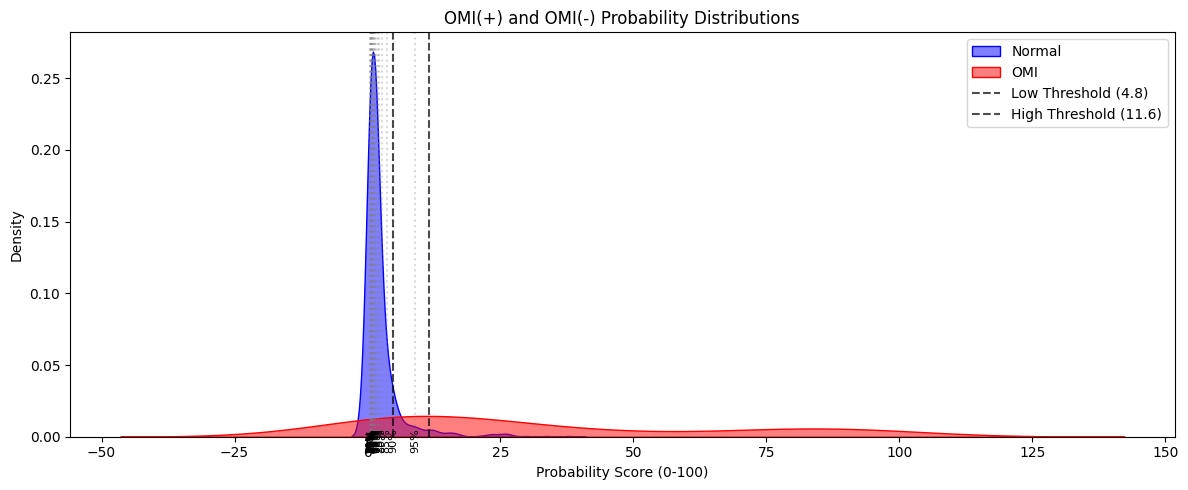

Evaluating multiple threshold combinations...

Top threshold combinations by overall utility:
    low_threshold  high_threshold  sensitivity       npv  specificity   ppv  \
19       3.222222            25.0     0.857143  0.990625     0.990838  0.72   
9        3.000000            25.0     0.857143  0.990506     0.990838  0.72   
69       4.333333            25.0     0.833333  0.989766     0.990838  0.72   
59       4.111111            25.0     0.833333  0.989691     0.990838  0.72   
49       3.888889            25.0     0.833333  0.989489     0.990838  0.72   

    utility_score  
19       0.889651  
9        0.889622  
69       0.883484  
59       0.883465  
49       0.883415  

Threshold combinations meeting clinical criteria (based on paper):
    low_threshold  high_threshold  low_percent  intermediate_percent  \
19       3.222222       25.000000    79.404467             17.493797   
9        3.000000       25.000000    78.411911             18.486352   
18       3.222222       23.

C:\Users\arthu\AppData\Local\Temp\ipykernel_104744\23679451.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_criteria['paper_score'] = (


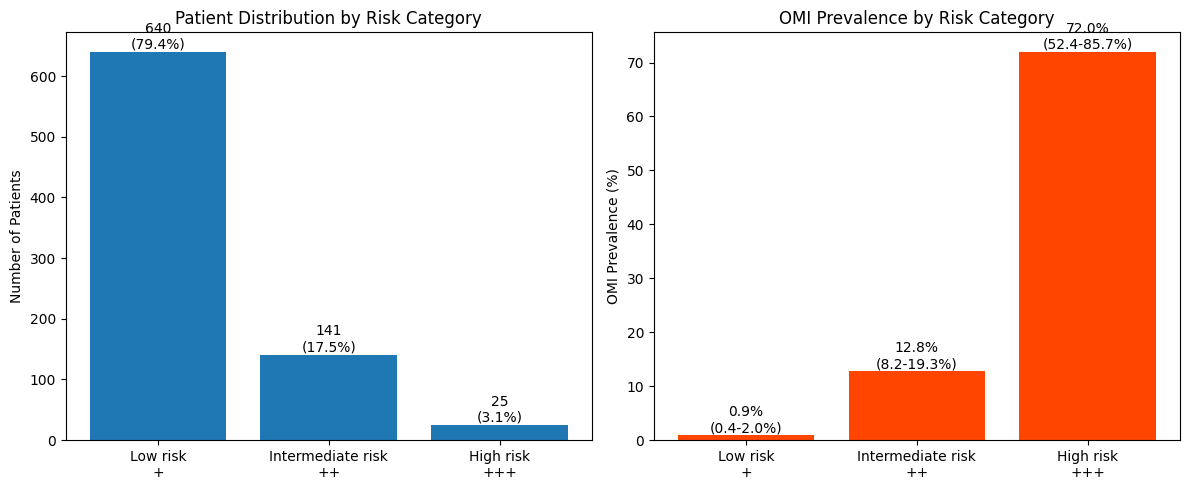


Risk Stratification with thresholds 3.2 and 25.0:
Low risk: 640 patients (79.4%)
Intermediate risk: 141 patients (17.5%)
High risk: 25 patients (3.1%)

OMI Prevalence with 95% CI:
Low risk: 0.9% (0.4-2.0%)
Intermediate risk: 12.8% (8.2-19.3%)
High risk: 72.0% (52.4-85.7%)

Rule-out Strategy (Low risk classified as negative) with 95% CI:
Sensitivity: 0.857 (0.722-0.933)
NPV: 0.991 (0.980-0.996)
Miss rate: 0.009 (0.004-0.020)

Rule-in Strategy (High risk classified as positive) with 95% CI:
Specificity: 0.991 (0.981-0.996)
PPV: 0.720 (0.524-0.857)
False discovery rate: 0.280 (0.143-0.476)


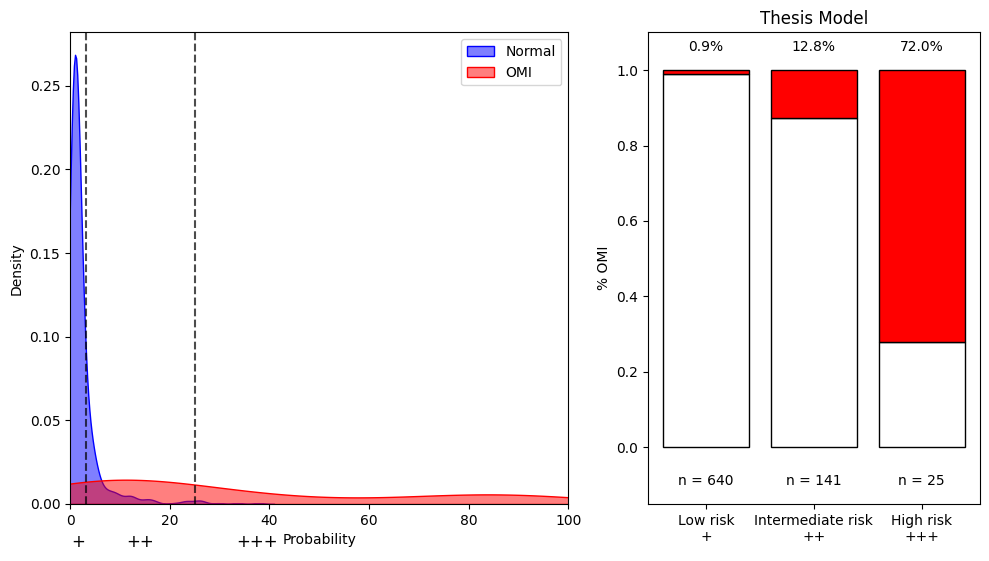

In [122]:
# Import the code above into your notebook

# Option 1: Determine optimal thresholds automatically
low_threshold, high_threshold = determine_optimal_thresholds(y_test, pred_probas_test)

# Option 2: Use the thresholds from the paper (5 and 20)
# low_threshold, high_threshold = 5, 20

# Evaluate the risk stratification with the determined thresholds
metrics = evaluate_risk_stratification(y_test, pred_probas_test, low_threshold, high_threshold)

# Create the final distribution plot similar to Figure 2b in the paper
fig = plot_final_distribution(y_test, pred_probas_test, low_threshold, high_threshold)

In [110]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<3.2, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=25, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

External Validation (Test)


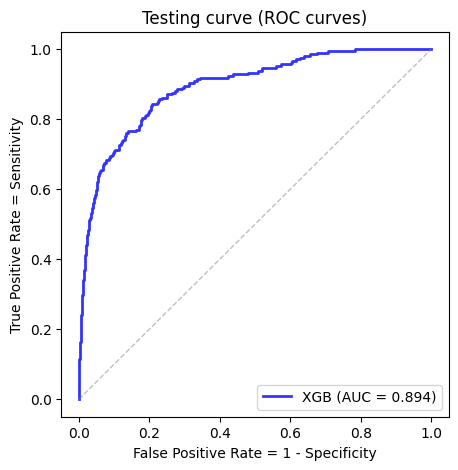

Val AUROC: 0.894 (95% CI: 0.870, 0.917)


In [123]:
print("External Validation (Test)")
# Evaluate on validation set
pred_probas_val = best_xgb.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Testing curve (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")

In [112]:
def calculate_rule_in_rule_out(y_true, pred_probas, low_threshold=3.2, high_threshold=25):
    """
    Calculate rule-in and rule-out metrics for the OMI risk score with 95% confidence intervals
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth labels (1 for OMI, 0 for non-OMI)
    pred_probas : array-like
        Predicted probabilities from the model
    low_threshold : float
        Threshold for low risk (default: 3.2)
    high_threshold : float
        Threshold for high risk (default: 25)
        
    Returns:
    --------
    dict
        Dictionary containing all the metrics with 95% CIs
    """
    from sklearn.metrics import confusion_matrix
    import numpy as np
    
    def calculate_wilson_ci(p, n, z=1.96):
        """
        Calculate Wilson score interval for a proportion
        
        Parameters:
        -----------
        p : float
            Proportion (e.g., sensitivity, specificity)
        n : int
            Sample size
        z : float
            z-score for desired confidence level (default 1.96 for 95% CI)
        
        Returns:
        --------
        tuple
            (lower_bound, upper_bound)
        """
        # Handle edge cases
        if n == 0:
            return (0.0, 1.0)
        
        # Wilson score interval calculation
        denominator = 1 + z**2/n
        center = (p + z**2/(2*n))/denominator
        half_width = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))/denominator
        
        lower_bound = max(0.0, center - half_width)
        upper_bound = min(1.0, center + half_width)
        
        return (lower_bound, upper_bound)
    
    # Scale probabilities to 0-100 range
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    
    # Create risk categories
    y_pred_str = np.full(len(y_true), 'Intermediate risk', dtype=object)
    y_pred_str[OMI_score < low_threshold] = 'Low risk'
    y_pred_str[OMI_score >= high_threshold] = 'High risk'
    
    # Get counts for each category
    low_risk_count = np.sum(y_pred_str == 'Low risk')
    intermediate_risk_count = np.sum(y_pred_str == 'Intermediate risk')
    high_risk_count = np.sum(y_pred_str == 'High risk')
    total_count = len(y_true)
    
    # Calculate risk distribution percentages
    low_risk_percent = low_risk_count / total_count * 100
    intermediate_risk_percent = intermediate_risk_count / total_count * 100
    high_risk_percent = high_risk_count / total_count * 100
    
    # Calculate OMI prevalence in each risk category
    low_risk_positives = np.sum((y_pred_str == 'Low risk') & (y_true == 1))
    intermediate_risk_positives = np.sum((y_pred_str == 'Intermediate risk') & (y_true == 1))
    high_risk_positives = np.sum((y_pred_str == 'High risk') & (y_true == 1))
    
    low_risk_prevalence = low_risk_positives / low_risk_count * 100 if low_risk_count > 0 else 0
    intermediate_risk_prevalence = intermediate_risk_positives / intermediate_risk_count * 100 if intermediate_risk_count > 0 else 0
    high_risk_prevalence = high_risk_positives / high_risk_count * 100 if high_risk_count > 0 else 0
    
    # Calculate CIs for prevalence estimates (converting to proportion for calculation)
    low_risk_prevalence_ci = calculate_wilson_ci(low_risk_prevalence/100, low_risk_count) if low_risk_count > 0 else (0, 0)
    intermediate_risk_prevalence_ci = calculate_wilson_ci(intermediate_risk_prevalence/100, intermediate_risk_count) if intermediate_risk_count > 0 else (0, 0)
    high_risk_prevalence_ci = calculate_wilson_ci(high_risk_prevalence/100, high_risk_count) if high_risk_count > 0 else (0, 0)
    
    # Convert CI back to percentage
    low_risk_prevalence_ci = (low_risk_prevalence_ci[0] * 100, low_risk_prevalence_ci[1] * 100)
    intermediate_risk_prevalence_ci = (intermediate_risk_prevalence_ci[0] * 100, intermediate_risk_prevalence_ci[1] * 100)
    high_risk_prevalence_ci = (high_risk_prevalence_ci[0] * 100, high_risk_prevalence_ci[1] * 100)
    
    # Rule-out strategy (treating low risk as negative)
    y_rule_out = (y_pred_str != 'Low risk').astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_rule_out).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    miss_rate = fn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Calculate 95% CIs for rule-out metrics
    sensitivity_ci = calculate_wilson_ci(sensitivity, tp + fn)
    npv_ci = calculate_wilson_ci(npv, tn + fn)
    miss_rate_ci = calculate_wilson_ci(miss_rate, tn + fn)
    
    # Rule-in strategy (treating high risk as positive)
    y_rule_in = (y_pred_str == 'High risk').astype(int)
    tn_in, fp_in, fn_in, tp_in = confusion_matrix(y_true, y_rule_in).ravel()
    
    specificity = tn_in / (tn_in + fp_in) if (tn_in + fp_in) > 0 else 0
    ppv = tp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    false_discovery_rate = fp_in / (tp_in + fp_in) if (tp_in + fp_in) > 0 else 0
    
    # Calculate 95% CIs for rule-in metrics
    specificity_ci = calculate_wilson_ci(specificity, tn_in + fp_in)
    ppv_ci = calculate_wilson_ci(ppv, tp_in + fp_in)
    false_discovery_rate_ci = calculate_wilson_ci(false_discovery_rate, tp_in + fp_in)
    
    return {
        "distribution": {
            "low_risk": {
                "count": int(low_risk_count),
                "percent": low_risk_percent,
                "omi_prevalence": low_risk_prevalence,
                "omi_prevalence_ci": low_risk_prevalence_ci
            },
            "intermediate_risk": {
                "count": int(intermediate_risk_count),
                "percent": intermediate_risk_percent,
                "omi_prevalence": intermediate_risk_prevalence,
                "omi_prevalence_ci": intermediate_risk_prevalence_ci
            },
            "high_risk": {
                "count": int(high_risk_count),
                "percent": high_risk_percent,
                "omi_prevalence": high_risk_prevalence,
                "omi_prevalence_ci": high_risk_prevalence_ci
            }
        },
        "rule_out": {
            "sensitivity": sensitivity,
            "sensitivity_ci": sensitivity_ci,
            "npv": npv,
            "npv_ci": npv_ci,
            "miss_rate": miss_rate,
            "miss_rate_ci": miss_rate_ci
        },
        "rule_in": {
            "specificity": specificity,
            "specificity_ci": specificity_ci,
            "ppv": ppv,
            "ppv_ci": ppv_ci,
            "false_discovery_rate": false_discovery_rate,
            "false_discovery_rate_ci": false_discovery_rate_ci
        }
    }

# Code to print results with confidence intervals
def print_metrics_with_ci(metrics):
    """
    Print metrics with confidence intervals in a well-formatted way
    
    Parameters:
    -----------
    metrics : dict
        Dictionary containing metrics from calculate_rule_in_rule_out function
    """
    print("\nRisk Distribution:")
    print(f"Low risk: {metrics['distribution']['low_risk']['count']} patients ({metrics['distribution']['low_risk']['percent']:.1f}%)")
    print(f"Intermediate risk: {metrics['distribution']['intermediate_risk']['count']} patients ({metrics['distribution']['intermediate_risk']['percent']:.1f}%)")
    print(f"High risk: {metrics['distribution']['high_risk']['count']} patients ({metrics['distribution']['high_risk']['percent']:.1f}%)")

    print("\nOMI Prevalence with 95% CI:")
    low_ci = metrics['distribution']['low_risk']['omi_prevalence_ci']
    int_ci = metrics['distribution']['intermediate_risk']['omi_prevalence_ci']
    high_ci = metrics['distribution']['high_risk']['omi_prevalence_ci']
    
    print(f"Low risk: {metrics['distribution']['low_risk']['omi_prevalence']:.1f}% ({low_ci[0]:.1f}-{low_ci[1]:.1f}%)")
    print(f"Intermediate risk: {metrics['distribution']['intermediate_risk']['omi_prevalence']:.1f}% ({int_ci[0]:.1f}-{int_ci[1]:.1f}%)")
    print(f"High risk: {metrics['distribution']['high_risk']['omi_prevalence']:.1f}% ({high_ci[0]:.1f}-{high_ci[1]:.1f}%)")

    print("\nRule-out Strategy (Low risk classified as negative) with 95% CI:")
    sens_ci = metrics['rule_out']['sensitivity_ci']
    npv_ci = metrics['rule_out']['npv_ci']
    miss_ci = metrics['rule_out']['miss_rate_ci']
    
    print(f"Sensitivity: {metrics['rule_out']['sensitivity']:.3f} ({sens_ci[0]:.3f}-{sens_ci[1]:.3f})")
    print(f"NPV: {metrics['rule_out']['npv']:.3f} ({npv_ci[0]:.3f}-{npv_ci[1]:.3f})")
    print(f"Miss rate: {metrics['rule_out']['miss_rate']:.3f} ({miss_ci[0]:.3f}-{miss_ci[1]:.3f})")

    print("\nRule-in Strategy (High risk classified as positive) with 95% CI:")
    spec_ci = metrics['rule_in']['specificity_ci']
    ppv_ci = metrics['rule_in']['ppv_ci']
    fdr_ci = metrics['rule_in']['false_discovery_rate_ci']
    
    print(f"Specificity: {metrics['rule_in']['specificity']:.3f} ({spec_ci[0]:.3f}-{spec_ci[1]:.3f})")
    print(f"PPV: {metrics['rule_in']['ppv']:.3f} ({ppv_ci[0]:.3f}-{ppv_ci[1]:.3f})")
    print(f"False discovery rate: {metrics['rule_in']['false_discovery_rate']:.3f} ({fdr_ci[0]:.3f}-{fdr_ci[1]:.3f})")

# Example usage
print("\nCalculating Rule-in and Rule-out Metrics for External Validation with 95% Confidence Intervals")
metrics_val = calculate_rule_in_rule_out(y_val, pred_probas_val)

# Print the results with confidence intervals
print_metrics_with_ci(metrics_val)


Calculating Rule-in and Rule-out Metrics for External Validation with 95% Confidence Intervals

Risk Distribution:
Low risk: 2269 patients (69.0%)
Intermediate risk: 833 patients (25.3%)
High risk: 185 patients (5.6%)

OMI Prevalence with 95% CI:
Low risk: 1.1% (0.8-1.7%)
Intermediate risk: 9.8% (8.0-12.1%)
High risk: 54.6% (47.4-61.6%)

Rule-out Strategy (Low risk classified as negative) with 95% CI:
Sensitivity: 0.876 (0.824-0.914)
NPV: 0.989 (0.983-0.992)
Miss rate: 0.011 (0.008-0.017)

Rule-in Strategy (High risk classified as positive) with 95% CI:
Specificity: 0.973 (0.966-0.978)
PPV: 0.546 (0.474-0.616)
False discovery rate: 0.454 (0.384-0.526)
